In [1]:
# Setup
!pip install --quiet --upgrade pip

# Install the dependencies.
!pip install --quiet -r requirements_tf.txt
!pip install wandb -q
!pip install opencv-python -q

In [9]:
# Restart the runtime by ending the process
exit()

wandb: 🚀 View run sinister-newt-109 at: https://wandb.ai/t-skorkowski/blue-marble/runs/4c09iz1r
wandb: Find logs at: wandb/run-20241030_115348-4c09iz1r/logs


In [12]:
import os
import matplotlib.pyplot as plt


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
import google.auth
from importlib import reload
from serving.constants import  BUCKET, IMG_SOURCE_PREFIX, HIST_DEST_PREFIX, HIST_BINS_LIST, SCALE, CROP, MONTHS, IMAGE_BATCH, NUM_BINS, MAP_NAN, NORMALIZE, LABELS_PATH, HEADER_PATH, SELECTED_BANDS
from serving.common import list_blobs_with_prefix
from serving.hist_training import (get_labels,
                                   #LstmModel,
                                   #TimeDependentDenseLstmModel,
                                   pen_low_lenient_high_loss,
                                   pen_low_loss,
                                   load_dataset_from_gcp,
                                   save_dataset_to_gcp,
                                   create_hist_dataset,
                                   train_wandb,
                                   train_model_data,
                                   plot_training_progress)
from serving.data import check_blob_prefix_exists, batch_check_blobs, get_varied_labels, check_blob_exists
import logging
import io
import itertools
import time

from keras.layers import LSTM, Dense, Dropout, Input, Normalization
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import wandb
from google.cloud import secretmanager

tf.config.run_functions_eagerly(True)

In [48]:
# Models
import keras
from keras.layers import LSTM, Dense, Dropout, Input, TimeDistributed, BatchNormalization
from tensorflow.keras.regularizers import l2
from serving.data import get_labels
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
import randomname
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
import tempfile
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

class GradientDebugCallback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        weights = self.model.trainable_weights
        grads = self.model.optimizer.get_gradients(self.model.total_loss, weights)
        print(f"Batch {batch}")
        print("Gradient norms:", [tf.norm(g).numpy() if g is not None else 0 for g in grads])


# Define the LSTM model
class LstmModel(keras.Model):
    def __init__(
        self,
        input_shape,
        lstm_layers=3,
        no_units=3,
        output_units=1,
        dropout_rate=0.2,
        val_size=10,
        kernel_initializer=tf.keras.initializers.RandomNormal()
    ):
        super(LstmModel, self).__init__()
        self.lstm_layers = lstm_layers
        self.no_units = no_units
        self.output_units = output_units
        self.dropout_rate = dropout_rate
        self.val_size = val_size

        self.input_layer = Input(shape=input_shape)
        self.batch_norm = BatchNormalization()
        
        # Define LSTM and Dense layers
        self.lstm_layers_list = []
        for i in range(lstm_layers):
            self.lstm_layers_list.append(
                LSTM(
                    units=no_units,
                    return_sequences=(i < lstm_layers - 1),
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal',
                    activation='tanh'
                )
            )
            
            if i < lstm_layers - 1:
                self.lstm_layers_list.append(Dropout(rate=dropout_rate))
        
        self.dense = Dense(
            units=output_units,
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
            bias_initializer=tf.keras.initializers.Constant(100.0)
        )
        
        self.job_name = randomname.get_name(adj=('emotions',), noun=('food'))
    
    def get_config(self):
        return {
           "lstm_layers": self.lstm_layers,
           "no_units": self.no_units,
           "val_size": self.val_size,
           "ouput_units": self.output_units,
           "dropout_rate": self.dropout_rate,
           "kernel_initializer": self.kernel_initializer
        }
    
    @classmethod
    def from_config(cls, config):
        # Convert the serialized initializer back to a TF initializer
        config['kernel_initializer'] = tf.keras.initializers.deserialize(
            config['kernel_initializer']
        )
        return cls(**config)
    
    @tf.function
    def call(self, inputs, training=False):
        # LSTM layers

        x = inputs
        #x = self.batch_norm(x, training=training)

        for lstm_layer in self.lstm_layers_list:
            x = lstm_layer(x)

        outputs = self.dense(x)

        return outputs

    def summary(self):
        super(LstmModel, self).summary()

    def compile(
        self, optimizer="adam", loss="mse", metrics=["mae"], learning_rate=0.001, **kwargs
    ):
        self.learning_rate = learning_rate

        # Dictionary to map optimizer names to their classes
        optimizers = {"adam": Adam, "nadam": Nadam, "rms": RMSprop}

        # Get the optimizer class from the dictionary
        optimizer_class = optimizers.get(optimizer.lower(), Adam)

        # Instantiate the optimizer with the specified learning rate
        optimizer_instance = optimizer_class(learning_rate=learning_rate, clipnorm=1.0)

        # Compile the model with the chosen optimizer, loss, and metrics
        tf.config.run_functions_eagerly(True)
        
        if loss != "mse" and "mse" not in metrics:
            metrics.append("mse")
        
        super(LstmModel, self).compile(
            optimizer=optimizer_instance, loss=loss, metrics=metrics, **kwargs
        )
        
    

    def fit(self, dataset, epochs=10):

        # Shuffle and batch the dataset
        # dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

        # Split the dataset
        val_size = self.val_size
        val_dataset = dataset.take(val_size)
        train_dataset = dataset.skip(val_size)

        # Setup tensorboard
        model_name = f"{NUM_BINS}_buckets_{len(HIST_BINS_LIST)}" + '-' + self.job_name + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        log_dir = "gs://vgnn/tensorboard-artifacts/logs/fit/" + model_name
        if not os.path.exists(os.path.dirname(log_dir)):
            os.makedirs(os.path.dirname(log_dir))
            
        
        # Early stopping callback
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        )

        
        # Train the model
        history = super(LstmModel, self).fit(
            train_dataset,
            epochs=epochs,
            # batch_size=batch_size,
            validation_data=val_dataset,
            callbacks=[early_stopping, GradientDebugCallback(), WandbMetricsLogger()]
        )
        
        responses_train = np.concatenate(
            [response.numpy() for _, response in train_dataset], axis=0
        )
        mean_response_train = np.mean(responses_train)

        responses_val = np.concatenate(
            [response.numpy() for _, response in val_dataset], axis=0
            )        

        if val_size == 0:
            self.naive_loss = np.nan
        else:
            self.naive_loss = pen_low_lenient_high_loss(responses_val, mean_response_train)        
        
        # Plot training progress
        plot_training_progress(history, self.naive_loss)

        # Evaluate the model
        loss = self.evaluate(val_dataset)

        self.save(f'gs://vgnn/models/{model_name}.h5')

        return history


class TimeDependentDenseLstmModel(LstmModel):
    def __init__(
        self,
        input_shape,
        lstm_layers=3,
        no_units=3,
        dense_layers_per_step=3,
        output_units=1,
        dropout_rate=0.2,
        val_size=10,
        kernel_initializer=tf.keras.initializers.RandomNormal()
    ):
        super(TimeDependentDenseLstmModel, self).__init__(
            input_shape,
            lstm_layers,
            no_units,
            output_units,
            dropout_rate,
            val_size,
            kernel_initializer
        )
        
        self.lstm_layers = lstm_layers
        self.dense_layers_per_step = dense_layers_per_step
        self.no_units = no_units
        self.val_size = val_size
        self.dropout_rate = dropout_rate
        self.kernel_initializer = kernel_initializer
        
        # Dense layer to process each time step using TimeDistributed
        self.time_distributed_dense = []
        # Create the dense layers that will be applied to each time step
        units = input_shape[-1] // 2
        for _ in range(dense_layers_per_step):
            self.time_distributed_dense.append(
                TimeDistributed(Dense(units=units, 
                                      activation="relu",
                                      kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                                      bias_initializer='ones', bias_regularizer=l2(0.01) ))
            )
            # units //= 2  # Halve units for each subsequent dense layer

    def get_config(self):
        config = super(TimeDependentDenseLstmModel, self).get_config()
        config.update({
            'dense_layers_per_step': self.dense_layers_per_step,
        })
        return config
    
    @tf.function
    def call(self, inputs, training=False):
        # Process each time step with a corresponding dense layer

        x = inputs
        # x = self.batch_norm(x, training=training)
        for dense_layer in self.time_distributed_dense:
            x = dense_layer(x)
        
        # Feed into LSTM layers
        for lstm_layer in self.lstm_layers_list:
            x = lstm_layer(x)

        outputs = self.dense(x)  # Final dense layer for output
        return outputs

In [3]:
# SETUP

# Create the Secret Manager client
client = secretmanager.SecretManagerServiceClient()

# Define the secret name and version
secret_name = "projects/1038596154733/secrets/wandb/versions/1"

# Access the secret
response = client.access_secret_version(name=secret_name)
secret_value = response.payload.data.decode('UTF-8')

#####
CREATE_DATASET = False
#####

start_time = time.perf_counter()
credentials, _ = google.auth.default()
bucket_name = BUCKET
directory_prefix = IMG_SOURCE_PREFIX
output_prefix = HIST_DEST_PREFIX
labels_data = "labels_combined.npy"
labels_header = "labels_header.npy"
months = MONTHS
map_nan = MAP_NAN
normalize = NORMALIZE
num_bins = NUM_BINS
client = storage.Client()
bucket = client.get_bucket(bucket_name)


batch_size = 20
img_range =  {"count_start":0,
              "no_records":10,
             "ascending": False}

In [4]:
map_nan = True
num_buckets_list = [60]
num_bands_list = [9]
CREATE_DATASET = False

for num_bins, num_bands in zip(num_buckets_list, num_bands_list):
    directory = f"dataset/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}"
    print(f"directory: {directory}")
    file_name =  "dataset.tfrecords" # "hist_dataset_medium" # 


    if CREATE_DATASET:
        # Generate all prefixes
        start_time = time.perf_counter()

        labels_df = get_varied_labels(**img_range)
        labels = list(zip(labels_df["county_name"],
                          labels_df["county_ansi"],
                     labels_df["state_ansi"],
                     labels_df["year"]))


        prefixes_hist = [f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}' 
                    for county,_, fips, year in labels
                        for month in months]

        # Batch check all prefixes
        results_hist = batch_check_blobs(bucket_name, prefixes_hist)

        # Generate get_input_img_params based on results
        get_input_img_params = [(county.capitalize(), fips, year)
                    for county, county_fips, fips, year in labels
                    if results_hist[f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}']
        ]

        print(f"Number of items to process: {len(get_input_img_params)}")

        end_time_dataset_info = time.perf_counter()
        print(f"Collecting dataset information: {end_time_dataset_info-start_time}")

        dataset, dataset_shape, hist_npy, labels_npy = create_hist_dataset(get_input_img_params, "labels_combined.npy", "labels_header.npy", num_bins=num_bins, num_bands=num_bands)
        end_time_dataset = time.perf_counter()

        print(f"Building dataset: {(end_time_dataset - end_time_dataset_info)/60:.02} minutes")

        # Save dataset
        save_dataset_to_gcp(hist_npy, labels_npy, directory=directory)
        print("Dataset created")
        print(directory,file_name,sep="/")
        CREATE_DATASET = False
    else:

        dataset, dataset_shape = load_dataset_from_gcp(directory=directory)
        print("Dataset loaded")

    input_shape = dataset_shape[1:]

directory: dataset/nan_map_True/norm_True/60_buckets_9_bands/60
Dataset loaded


In [4]:
# Sample labels
label_data = np.load(labels_data, allow_pickle=True)
label_header = np.load(labels_header, allow_pickle=True)
label_df = pd.DataFrame(label_data, columns=label_header)
label_df[label_df["county_name"]=='Williams'.upper()]

,commodity_desc,reference_period_desc,year,state_ansi,state_name,county_ansi,county_name,target,source_file
1122,CORN,YEAR,2016,39,OHIO,171,WILLIAMS,169.1,USDA_Corn_County_2016.csv
2619,CORN,YEAR,2017,39,OHIO,171,WILLIAMS,167.3,USDA_Corn_County_2017.csv
3994,CORN,YEAR,2018,39,OHIO,171,WILLIAMS,182.0,USDA_Corn_County_2018.csv
5275,CORN,YEAR,2019,39,OHIO,171,WILLIAMS,156.3,USDA_Corn_County_2019.csv
6845,CORN,YEAR,2020,39,OHIO,171,WILLIAMS,143.9,USDA_Corn_County_2020.csv
8274,CORN,YEAR,2021,38,NORTH DAKOTA,105,WILLIAMS,58.0,USDA_Corn_County_2021.csv
8350,CORN,YEAR,2021,39,OHIO,171,WILLIAMS,189.5,USDA_Corn_County_2021.csv
9884,CORN,YEAR,2022,39,OHIO,171,WILLIAMS,187.9,USDA_Corn_County_2022.csv


In [17]:
normalizer = tf.keras.layers.Normalization(axis=-1)

#take subset
batch_size = 5

# Train test split
test_train_split = 0.8
train_size = int(dataset_shape[0] * test_train_split / batch_size)
val_size = int(train_size * (1-test_train_split))

batched_dataset = dataset.batch(batch_size, drop_remainder=True)

test_dataset = batched_dataset.skip(train_size)
train_dataset = batched_dataset.take(train_size)

# Adapt normalizer on unbatched training data
normalizer.adapt(train_dataset.map(lambda x, y: x))


# 3. Apply normalization to both datasets
train_dataset = train_dataset.map(lambda x, y: (normalizer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalizer(x), y))

# # Then batch the datasets
# test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
# train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

train_dataset = train_dataset.shuffle(buffer_size=10000)
print(f"Train size: {train_size} \nValidation size: {val_size}")
print("Data sets have been setup")

Train size: 8 
Validation size: 1
Data sets have been setup


In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    print("Input stats:")
    print("Mean:", tf.reduce_mean(inputs))
    print("Std:", tf.math.reduce_std(inputs))
    print("Min:", tf.reduce_min(inputs))
    print("Max:", tf.reduce_max(inputs))
    
    print("\nTarget stats:")
    print("Mean:", tf.reduce_mean(targets))
    print("Std:", tf.math.reduce_std(targets))

In [ ]:
# directory = "dataset/nan_map_False/norm_True/60_buckets_9_bands/60"
# model_name = "32_buckets_9-kind-croissant-20241029-045508.tf"

# epochs = 20
# train_model_data(model_name, directory)

In [32]:
for x, y in train_dataset.take(1):
    feature = x[0].numpy()

In [49]:
wandb.init(
        # set the wandb project where this run will be logged
        project="blue-marble")

model = TimeDependentDenseLstmModel(input_shape = input_shape,
                                lstm_layers = 3,
                                dense_layers_per_step = 17,
                                no_units = 5,
                                val_size = val_size,
                                dropout_rate = 0.3,
                                kernel_initializer = tf.keras.initializers.RandomUniform(seed=42))
model.compile(optimizer= "nadam",
              learning_rate = 0.04038111849659211,
              loss=pen_low_loss)

for x, y in train_dataset.take(1):
    initial_pred = model(x)
    print("Initial predictions:", initial_pred.numpy()[:5])
    print("Initial predictions std:", np.std(initial_pred))
    print("Target values:", y.numpy()[:5])

print("Model compiled")

history = model.fit(train_dataset, epochs=15)
wandb.finish() 

epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▇▂▄▆▂▁▄▃▃▂▂█▇▂▃
epoch/mae,█▆▄█▃▁▄▃▃▄▆▆▅▃▃
epoch/mse,█▇▆█▅▁▆▄▄▅▇▇▇▅▄
epoch/val_loss,▂▂▅▇███▂▅█▅██▁█
epoch/val_mae,▅▁▇█▄▄▄▁▇▄▇▄█▃▄
epoch/val_mse,▃▁▅█▃▃▃▁▅▃▅▃▇▂▃
epoch/epoch,14
epoch/learning_rate,0.04038
epoch/loss,5153.18018


Initial predictions: [[99.99836]
 [99.99836]
 [99.99836]
 [99.99836]
 [99.99836]]
Initial predictions std: 0.0
Target values: [[150. ]
 [150.7]
 [163.1]
 [175.6]
 [ 50. ]]
Model compiled
Epoch 1/15


AttributeError: 'Nadam' object has no attribute 'get_gradients'

In [8]:
secret_value

'6a41c5a7d5d063e33b4bea24275d0b3d7afd3865'

In [7]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


True

In [ ]:

# Define the initializers you want to test
initializers = [
    tf.keras.initializers.RandomNormal(seed=42),
    tf.keras.initializers.RandomUniform(seed=42),
    tf.keras.initializers.HeNormal(seed=42),
    tf.keras.initializers.GlorotUniform(seed=42)
]

sweep_configuration = {
    "name": "bm_sweep",
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "validation_loss"},
    "count": 200,
    "parameters": {
        "lstm_layers_units": {"values": [(0,0), (3,5), (10,25)]},
        "dense_layers_per_step": {"values": [10, 17, 27]},
        "dropout_rate": {"values": [0.1, 0.2, 0.3]},
        "kernel_initializer": {"values": [0,1,2,3]},
        "num_bins_num_bands": {"values": [(12, 3), (12,9), (32,9), (60,3), (60,9)]},
        "lr": {"distribution": "uniform",
               "min": 0.0001,
               "max": 0.1},
        "batch_size": {"values": [16, 32, 64]},
        "epochs": {"values": [20]},
        "optimizer": {"values": ["adam", "rms", "nadam"]},
    },
}

sweep_id = wandb.sweep(sweep_configuration,
                      project="blue-marble")
wandb.agent(sweep_id, function=train_wandb)



In [7]:
wandb.finish()

epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▅▁
epoch/mae,█▇▁
epoch/mse,█▇▁
epoch/val_loss,▂█▁
epoch/val_mae,▁█▃
epoch/val_mse,▁█▄
epoch/epoch,2
epoch/learning_rate,0.04038
epoch/loss,16149.87109


In [19]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 99ms/step - loss: 19518.5488 - mae: 131.6927 - mse: 20154.2793


[19518.548828125, 131.6927490234375, 20154.279296875]

In [22]:
print(model.job_name)

tf.Tensor(4171.9155, shape=(), dtype=float32)
lively-foie-gras


In [ ]:
for layer in model.layers:
    # Get weights for the layer
    weights = layer.get_weights()
    
    # Check if the layer has weights
    if weights:
        print(f"Layer: {layer.name}")
        for i, weight in enumerate(weights):
            print(f"  Weight {i+1} shape: {weight.shape}")
            print(f"  Weight {i+1} values: \n{weight}\n")
    else:
        print(f"Layer: {layer.name} has no weights.")

In [46]:
predictions = model.predict(test_dataset)

2/2 [==============================] - 0s 114ms/step


In [47]:
predictions

array([[100.288155],
       [100.288155],
       [100.288155],
       [100.288155],
       [100.288155],
       [100.288155],
       [100.288155],
       [100.288155],
       [100.288155],
       [100.288155]], dtype=float32)

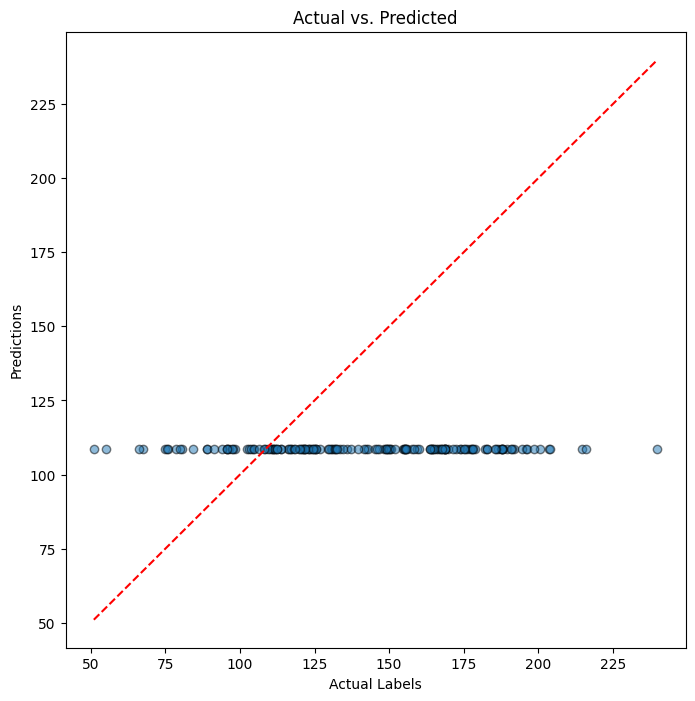

In [13]:
actual_labels = np.concatenate([response.numpy() for _, response in test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [ ]:
for layer in model.layers:
    print(layer.weights)